<a href="https://colab.research.google.com/github/cfsarmiento/GenAI-Research/blob/main/chatgpt_poll_composite_vars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ChatGPT Poll Composite Var creation
Modified by: EL

Things added, changed:
- Added helper class for PCA-weighted composite socre creation
- Read the ChatGPT-Clean.csv data
- Relabeled the variables for readability purposes (may still need more changes)
- Recoded Likert vars to numbers (int)
- COmpute composite scores and conbach alphas on subsets of variables.

Singleton variable are due to the fact that the cronbach-alpha coeff was below 0.7


In [263]:
#!pip install researchpy --quiet
#!pip install vaderSentiment --quiet
#!pip install pingouin --quiet
!pip install openpyxl --quiet

In [264]:
# Imports
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import researchpy as rp  # for statistical tests
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # for sentiment analysis
import warnings
warnings.filterwarnings('ignore')

## Helper class - PCA-weighted  composite score creation

In [265]:
class LikertCompositeCalculator:
    def __init__(self, data):
        # Standardization: This is needed for PCA - values are measured in stddevs:  (xi-xi_mean)/xi_sd
        # Also to be able t ocompare likert scale variables with different scales
        self.data = zscore(data, ddof=1)

    def calc_ca(self):
        # Calculated manually (checking the package)
        k = self.data.shape[1]
        if k>1:
          variance_sum = self.data.var(axis=0, ddof=1).sum()
          total_variance = self.data.sum(axis=1).var(ddof=1)
          cronbach_alpha = (k / (k - 1)) * (1 - (variance_sum / total_variance))
        else:
          cronbach_alpha = 1
        return cronbach_alpha

    def calc2_ca(self):
        # USing pingouin
        if  self.data.shape[1] >1:
          cronbach_alpha =pg.cronbach_alpha(self.data)
        else:
          cronbach_alpha = 1
        return cronbach_alpha

    def calc_composite_score(self):
        # Step 1: Perform PCA (data already standardized)
        pca = PCA()
        pca.fit(self.data)

        # Step 2: Calculate Weights
        weights = pca.components_[0] / np.sum(pca.components_[0])

        # Step 3: Calculate Composite Scores
        composite_scores = np.dot(self.data, weights)

        return composite_scores, weights

## Read in clean poll results

In [266]:
# Read in clean poll results
# I placed the file you provided in my website at Marist, was easier to load the data for me
data = pd.read_csv('https://foxweb.marist.edu/users/jf4n/Research/ChatGPTSurvey/ChatGPT-Clean.csv')

In [267]:
data.sample(20)

,Q2,Q4,Q5,Q6,Q7_1,Q7_2,Q7_3,Q8_1,Q8_2,Q8_3,...,Q15_9,Q17,Q19,Q21,Q22,Q23,sex,age,occupation/school,student/faculty
255,A good amount,From a friend,To aid in completion of a project,Curiosity,Neither agree nor disagree,Neither agree nor disagree,Somewhat agree,Somewhat disagree,Neither agree nor disagree,Somewhat disagree,...,Strongly agree,Strongly agree,Strongly agree,Very likely,Very likely,ChatGPT can increase productivity but at the s...,Female,18-21,Social & Behavioral Sciences,Student
273,A good amount,Other,To obtain significant help with a project,To aid in completion of a project,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,Strongly agree,Somewhat agree,Somewhat agree,...,Strongly agree,Strongly agree,Strongly agree,Very likely,Neither likely nor unlikely,I think its cool,Female,18-21,Social & Behavioral Sciences,Student
99,A good amount,From the news,To aid in completion of a project,To get started with a project,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Somewhat disagree,Somewhat agree,...,Neither agree nor disagree,Strongly agree,Strongly agree,Very likely,Somewhat unlikely,ChapGPT is a good resource to get quick feedba...,Male,18-21,Communications & Arts,Student
8,Nothing at all,None,Curiosity,To obtain significant help with a project,Somewhat agree,Strongly agree,Neither agree nor disagree,Strongly agree,Somewhat agree,Strongly agree,...,Somewhat agree,Strongly agree,Strongly agree,Somewhat likely,Very likely,NaN,Female,18-21,Liberal Arts,Student
40,A great deal,From the news,To obtain significant help with a project,To aid in completion of a project,Somewhat agree,Strongly agree,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,Somewhat agree,...,Somewhat agree,Strongly agree,Neither agree nor disagree,Neither likely nor unlikely,Very unlikely,I think it is a great piece of technology that...,Female,22-25,CS & Math,Student
176,A great deal,From the news,To obtain significant help with a project,To aid in completion of a project,Strongly agree,Strongly agree,Strongly agree,Neither agree nor disagree,Strongly agree,Strongly agree,...,Somewhat agree,Neither agree nor disagree,Strongly agree,Very likely,Very likely,ChatGPT can help students in both a beneficial...,Female,18-21,Science,Student
96,A great deal,From the news,To get started with a project,To get started with a project,Somewhat agree,Strongly agree,Neither agree nor disagree,Somewhat agree,Somewhat agree,Somewhat agree,...,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat likely,Somewhat unlikely,ChatGPT is likely a technology fear based news...,Non-binary / third gender,18-21,Communications & Arts,Student
117,A great deal,From the news,To get started with a project,To aid in completion of a project,Strongly agree,Somewhat disagree,Neither agree nor disagree,Strongly agree,Somewhat agree,Somewhat agree,...,Somewhat agree,Somewhat agree,Somewhat agree,NaN,Somewhat likely,NaN,Male,18-21,CS & Math,Student
355,A good amount,From the news,To obtain significant help with a project,Curiosity,Somewhat agree,Strongly agree,NaN,Somewhat agree,Somewhat disagree,Somewhat agree,...,Strongly disagree,Somewhat agree,Somewhat agree,NaN,NaN,NaN,Female,30-33,NaN,NaN
297,A great deal,From the news,To get started with a project,Curiosity,Somewhat agree,Somewhat agree,Somewhat agree,Strongly agree,Somewhat agree,Neither agree nor disagree,...,Somewhat agree,Strongly agree,Somewhat agree,Somewhat likely,Neither likely nor unlikely,NaN,Female,18-21,Social & Behavioral Sciences,Student


In [268]:
#data.info()

In [269]:
new_column_names = {'Q2':    'Q2_AWARENESS',
                    'Q4':    'Q4_SOURCE',
                    'Q5':    'Q5_REASON_STUDENT',
                    'Q6':    'Q6_REASON_PROF',
                    'Q7_1':  'Q71_BENEFITS',
                    'Q7_2':  'Q72_LIMITATIONS',
                    'Q7_3':  'Q73_IMPLICATIONS',
                    'Q8_1':  'Q81_LIKELY_PRODUCTIVE',
                    'Q8_2':  'Q82_PRODUCTIVE_STUDENT',
                    'Q8_3':  'Q83_PRODUCTIVE_PROF',
                    'Q8_4':  'Q84_PRODUCTIVE_PERSON',
                    'Q9_1':  'Q91_PLAG_STUDENT',
                    'Q9_2':  'Q92_PLAG_PROF',
                    'Q9_3':  'Q93_PLAG_PERSON',
                    'Q9_4':  'Q94_CAUGHT_PLAG',
                    'Q10':   'Q10_SOC_IMPACT',
                    'Q11':   'Q11_HIGHERED_BENEFIT',
                    'Q12':   'Q12_RESP_USE',
                    'Q13':   'Q13_FREQ_USE',
                    'Q14':   'Q14_RESP_REASON_USE',
                    'Q15_1': 'Q151_RESP_WILL_USE',
                    'Q15_2': 'Q152_RESP_BENEFIT',
                    'Q15_3': 'Q153_RESP_PRODUCTIVE',
                    'Q15_4': 'Q154_RESP_FEEL_PLAG',
                    'Q15_5': 'Q155_RESP_TRUST_OUTPUT',
                    'Q15_6': 'Q156_RESP_USE_OUTPUT',
                    'Q15_7': 'Q157_RESP_WILL_PLAG',
                    'Q15_8': 'Q158_RESP_PRODUCTIVE',
                    'Q15_9': 'Q159_RESP_IMPACTED',
                    'Q17':   'Q17_ACCURATE_OUTPUT_DELIVERY',
                    'Q19':   'Q19_ACCURATE_OUTPUT_COUNTRY',
                    'Q21':   'Q21_TRUST_OUTPUT_COAT',
                    'Q22':   'Q22_USE_OUTPUT_COAT',
                    'Q23':   'Q23_THOUGHTS',
                    'sex':   'GENDER',
                    'age':   'AGE_RANGE',
                    'occupation/school': 'OCCUP_SCHOOL',
                    'student/faculty':   'OCCUPATION'

					}

In [270]:
df = data.rename(columns=new_column_names)
#df.info()

## Check missing values

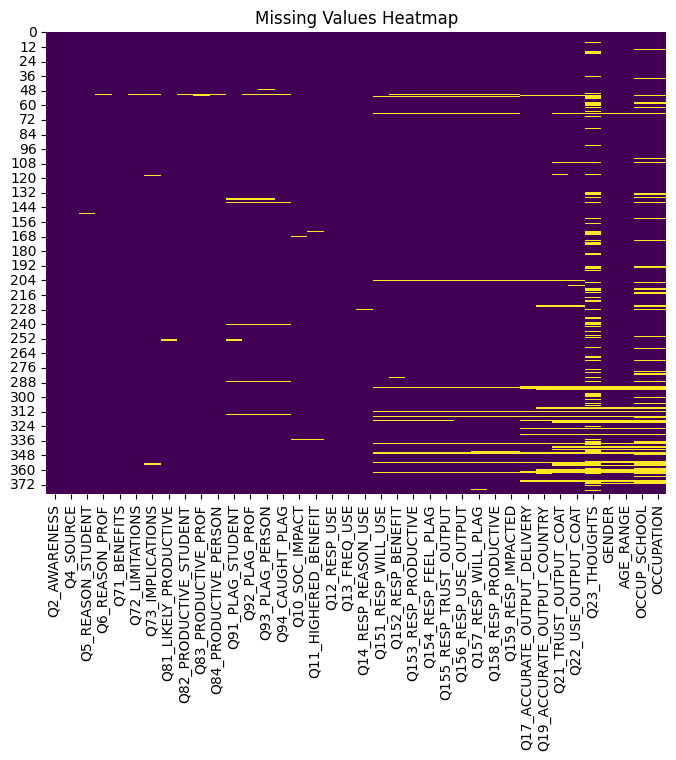

In [271]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

## Remove nulls and drop Q23-THOUGHTS

In [272]:
df1 = df.drop("Q23_THOUGHTS", axis=1).dropna()
df1['OCCUPATION'] = df1['OCCUPATION'].replace('Professor/Faculty', 'Instructor')

print(df1.shape[0])
#df1["OCCUPATION"].sample(20)

302


## Plot  the distribution by demographic vars

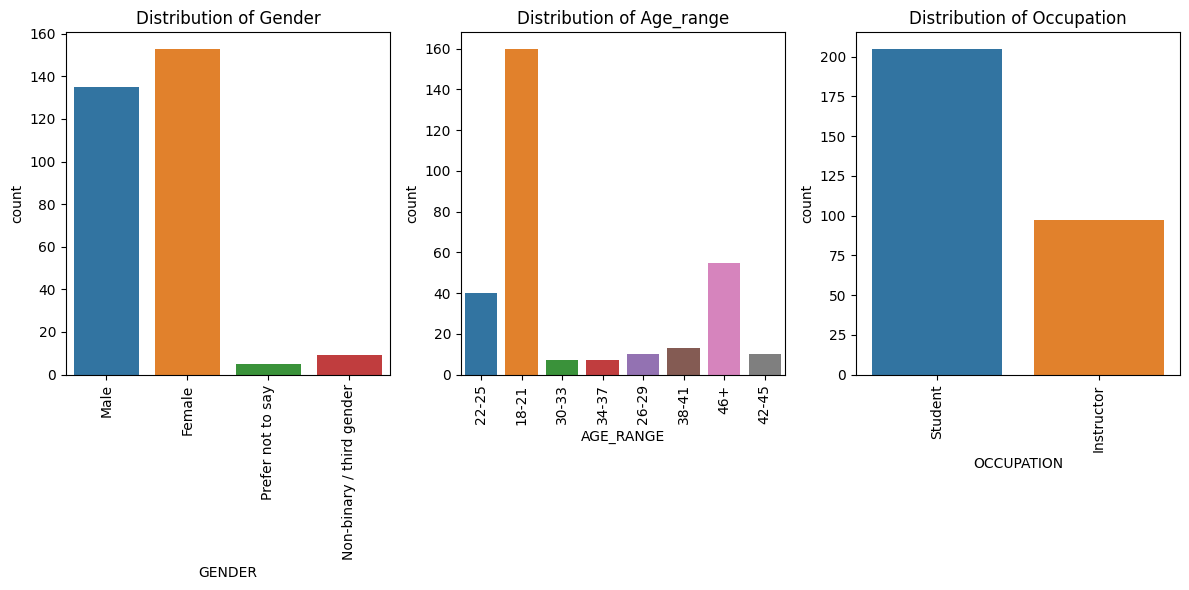

In [273]:
# Set up the 3x1 plot grid
demog_features =['GENDER','AGE_RANGE','OCCUPATION']
fig, axes = plt.subplots(nrows=1, ncols=len(demog_features), figsize=(12, 6))

# Loop through each demog_feature and create a count plot
for i, column in enumerate(demog_features):
    sns.countplot(x=column, data=df1, ax=axes[i])
    axes[i].set_title(f'Distribution of {column.capitalize()}')
    axes[i].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [274]:
df1['Q4_SOURCE'].unique()

array(['From the news', 'From a friend', 'From a family member', 'None',
       'From this questionnaire', 'Other', 'From a colleague'],
      dtype=object)

## Recoding of Likert vars

In [275]:
##Likert (1-3) vars ----------------------------------------------------------------
likert3_mapping1 = {'Very much so':1,
                   'Somewhat':2,
                   'Not at all':3}
df1['Q10_SOC_IMPACT'] = df1['Q10_SOC_IMPACT'].map(likert3_mapping1)
df1['Q11_HIGHERED_BENEFIT'] = df1['Q11_HIGHERED_BENEFIT'].map(likert3_mapping1)

##Likert (1-4) vars ---------------------------------------------------------------
likert4_mapping1 = {'A great deal':1,
                   'A good amount':2,
                   'A little':1,
                   'Nothing at all':4}

df1['Q2_AWARENESS'] = df1['Q2_AWARENESS'].map(likert4_mapping1)


likert4_mapping2 = {'Quite a lot':1,
                   'A good amount':2,
                   'A little':1,
                   'Not at all':4}

df1['Q12_RESP_USE'] = df1['Q12_RESP_USE'].map(likert4_mapping2)


likert4_mapping3 = {'11 or more times':1,
                    '6 to 10':2,
                    '1 to 5':3,
                    '0':4}

df1['Q13_FREQ_USE'] = df1['Q13_FREQ_USE'].map(likert4_mapping3)

##Likert (1-5) vars -----------------------------------------------
likert5_mapping1 = {'Strongly agree':1,
                  'Somewhat agree':2,
                  'Neither agree nor disagree':3,
                  'Somewhat disagree':4,
                  'Strongly disagree':5}

inverse_likert5_mapping1 = {'Strongly agree':5,
                           'Somewhat agree':4,
                           'Neither agree nor disagree':3,
                           'Somewhat disagree':2,
                           'Strongly disagree':1}

for colname  in ['Q71_BENEFITS','Q72_LIMITATIONS','Q73_IMPLICATIONS',
                'Q81_LIKELY_PRODUCTIVE','Q82_PRODUCTIVE_STUDENT','Q83_PRODUCTIVE_PROF','Q84_PRODUCTIVE_PERSON',
                'Q91_PLAG_STUDENT','Q92_PLAG_PROF','Q93_PLAG_PERSON','Q94_CAUGHT_PLAG',
                'Q151_RESP_WILL_USE','Q152_RESP_BENEFIT','Q153_RESP_PRODUCTIVE','Q154_RESP_FEEL_PLAG',
                'Q155_RESP_TRUST_OUTPUT','Q156_RESP_USE_OUTPUT','Q157_RESP_WILL_PLAG','Q158_RESP_PRODUCTIVE','Q159_RESP_IMPACTED',
                'Q17_ACCURATE_OUTPUT_DELIVERY','Q19_ACCURATE_OUTPUT_COUNTRY'] :

     #keep direction (1-5)
     if colname in ['Q71_BENEFITS', 'Q72_LIMITATIONS','Q73_IMPLICATIONS',
                    'Q81_LIKELY_PRODUCTIVE','Q82_PRODUCTIVE_STUDENT','Q83_PRODUCTIVE_PROF','Q84_PRODUCTIVE_PERSON',
                    'Q91_PLAG_STUDENT','Q92_PLAG_PROF','Q93_PLAG_PERSON',
                    'Q151_RESP_WILL_USE','Q152_RESP_BENEFIT','Q153_RESP_PRODUCTIVE',
                    'Q155_RESP_TRUST_OUTPUT','Q156_RESP_USE_OUTPUT','Q158_RESP_PRODUCTIVE','Q159_RESP_IMPACTED',
                    'Q17_ACCURATE_OUTPUT_DELIVERY','Q19_ACCURATE_OUTPUT_COUNTRY']:
        df1[colname] = df1[colname].map(likert5_mapping1)
     else:
        df1[colname] = df1[colname].map(inverse_likert5_mapping1)


likert5_mapping2 = {'To obtain significant help with a project':1,
                    'To aid in completion of a project':2,
                    'To get started with a project':3,
                    'Curiosity':4,
                    'I have not used ChatGPT':5}
df1['Q14_RESP_REASON_USE'] = df1['Q14_RESP_REASON_USE'].map(likert5_mapping2)

likert5_mapping3 = {'Very likely':1,
                    'Somewhat likely':2,
                    'Neither likely nor unlikely':3,
                    'Somewhat unlikely':4,
                    'Very unlikely':5}
df1['Q21_TRUST_OUTPUT_COAT'] = df1['Q21_TRUST_OUTPUT_COAT'].map(likert5_mapping3)
df1['Q22_USE_OUTPUT_COAT'] = df1['Q22_USE_OUTPUT_COAT'].map(likert5_mapping3)


likert5_mapping4 = {'To obtain significant help with a project':1,
                    'To aid in completion of a project':2,
                    'To get started with a project':3,
                    'Curiosity':4,
                    'Other; please specify':5}
df1['Q5_REASON_STUDENT'] = df1['Q5_REASON_STUDENT'].map(likert5_mapping4)
df1['Q6_REASON_PROF'] = df1['Q6_REASON_PROF'].map(likert5_mapping4)


In [276]:
df1

,Q2_AWARENESS,Q4_SOURCE,Q5_REASON_STUDENT,Q6_REASON_PROF,Q71_BENEFITS,Q72_LIMITATIONS,Q73_IMPLICATIONS,Q81_LIKELY_PRODUCTIVE,Q82_PRODUCTIVE_STUDENT,Q83_PRODUCTIVE_PROF,...,Q158_RESP_PRODUCTIVE,Q159_RESP_IMPACTED,Q17_ACCURATE_OUTPUT_DELIVERY,Q19_ACCURATE_OUTPUT_COUNTRY,Q21_TRUST_OUTPUT_COAT,Q22_USE_OUTPUT_COAT,GENDER,AGE_RANGE,OCCUP_SCHOOL,OCCUPATION
0,1,From the news,1,2,4,4,4,3,3,3,...,5,1,2,3,5,5,Male,22-25,Management,Student
1,2,From the news,3,2,1,1,1,1,2,1,...,2,1,1,3,2,2,Male,18-21,CS & Math,Student
2,2,From a friend,3,3,1,2,2,1,2,2,...,2,2,1,1,2,2,Female,18-21,CS & Math,Student
3,1,From a family member,2,2,1,1,1,2,2,2,...,2,1,2,2,2,2,Female,18-21,CS & Math,Student
4,4,From a friend,4,1,1,2,2,1,3,1,...,2,2,1,4,1,2,Female,18-21,CS & Math,Student
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,1,From the news,1,3,1,1,1,2,2,2,...,2,2,1,3,4,5,Female,30-33,Professor/Faculty,Instructor
375,2,From the news,1,4,3,1,1,3,5,4,...,3,2,5,3,5,5,Prefer not to say,34-37,Professor/Faculty,Instructor
377,2,From a family member,2,2,1,2,1,2,4,4,...,4,2,2,3,2,4,Female,22-25,Social & Behavioral Sciences,Student
378,1,From the news,2,4,1,3,5,1,1,1,...,1,1,1,3,2,3,Female,18-21,Social & Behavioral Sciences,Student


## Now we create subsets, compute reliability and create composites

In [277]:
# Example usage
subset_dict = {
    'AWARENESS': ['Q2_AWARENESS'],
    'REASON_STUDENT': ['Q5_REASON_STUDENT'],
    'REASON_PROFESSIONAL': ['Q6_REASON_PROF'],
    'BENEFITS': ['Q71_BENEFITS'],
    'LIMITATIONS': ['Q72_LIMITATIONS'],
    'IMPLICATIONS': ['Q73_IMPLICATIONS'],
    'WORK_PRODUCTIVITY': ['Q81_LIKELY_PRODUCTIVE','Q82_PRODUCTIVE_STUDENT','Q83_PRODUCTIVE_PROF','Q84_PRODUCTIVE_PERSON'],
    'PLAGIARISM': ['Q91_PLAG_STUDENT','Q92_PLAG_PROF','Q93_PLAG_PERSON'],
    'SOCIAL_IMPACT': ['Q10_SOC_IMPACT'],
    'HIGHERED_BENEFIT': ['Q11_HIGHERED_BENEFIT'],
    'USAGE': ['Q12_RESP_USE','Q13_FREQ_USE','Q14_RESP_REASON_USE'],
    'RESP_USE_TRUST_BENEF': ['Q151_RESP_WILL_USE','Q152_RESP_BENEFIT','Q153_RESP_PRODUCTIVE','Q154_RESP_FEEL_PLAG',
                              'Q155_RESP_TRUST_OUTPUT','Q156_RESP_USE_OUTPUT','Q157_RESP_WILL_PLAG','Q158_RESP_PRODUCTIVE','Q159_RESP_IMPACTED'],
    'ACCURACY': ['Q17_ACCURATE_OUTPUT_DELIVERY','Q19_ACCURATE_OUTPUT_COUNTRY'],
    'TRUST': ['Q21_TRUST_OUTPUT_COAT','Q22_USE_OUTPUT_COAT']
}
composite_info = []
df2 = pd.DataFrame()

for subset_name, subset_variables in subset_dict.items():
        subset = df1[subset_variables]
        lcc = LikertCompositeCalculator(subset)

        # Add the composite variable to the original DataFrame
        composite_var_name = subset_name
        composite_score, weights = lcc.calc_composite_score()
        df2[composite_var_name] = composite_score

        # Calculate Cronbach's alpha
        cronbach_alpha = lcc.calc_ca()
        #print(subset_name,list(zip(subset_variables,weights)),lcc.calc_ca(),'\n' )

        # Add information to the composite info list
        composite_info.append({'SubsetName': subset_name,'subset': list(zip(subset_variables,weights)), 'CronbachAlpha': cronbach_alpha})

# Create a new df, augmented with the composites
result_df = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)

# Create a DataFrame to store composite information
composite_info_df = pd.DataFrame(composite_info)


In [278]:
composite_info_df

,SubsetName,subset,CronbachAlpha
0,AWARENESS,"[(Q2_AWARENESS, 1.0)]",1.000000
1,REASON_STUDENT,"[(Q5_REASON_STUDENT, 1.0)]",1.000000
2,REASON_PROFESSIONAL,"[(Q6_REASON_PROF, 1.0)]",1.000000
3,BENEFITS,"[(Q71_BENEFITS, 1.0)]",1.000000
4,LIMITATIONS,"[(Q72_LIMITATIONS, 1.0)]",1.000000
5,IMPLICATIONS,"[(Q73_IMPLICATIONS, 1.0)]",1.000000
6,WORK_PRODUCTIVITY,"[(Q81_LIKELY_PRODUCTIVE, 0.2695951460824908), ...",0.727454
7,PLAGIARISM,"[(Q91_PLAG_STUDENT, 0.3303857124010513), (Q92_...",0.791905
8,SOCIAL_IMPACT,"[(Q10_SOC_IMPACT, 1.0)]",1.000000
9,HIGHERED_BENEFIT,"[(Q11_HIGHERED_BENEFIT, 1.0)]",1.000000


In [279]:
result_df

,Q2_AWARENESS,Q4_SOURCE,Q5_REASON_STUDENT,Q6_REASON_PROF,Q71_BENEFITS,Q72_LIMITATIONS,Q73_IMPLICATIONS,Q81_LIKELY_PRODUCTIVE,Q82_PRODUCTIVE_STUDENT,Q83_PRODUCTIVE_PROF,...,LIMITATIONS,IMPLICATIONS,WORK_PRODUCTIVITY,PLAGIARISM,SOCIAL_IMPACT,HIGHERED_BENEFIT,USAGE,RESP_USE_TRUST_BENEF,ACCURACY,TRUST
0,1,From the news,1,2,4,4,4,3,3,3,...,2.171730,2.373974,0.705744,-1.463215,0.969679,1.707759,0.895819,1.543423,0.254953,1.750332
1,2,From the news,3,2,1,1,1,1,2,1,...,-1.022405,-0.821896,-0.721571,-0.073755,-0.907521,-1.149544,-0.751619,-0.549300,-0.296804,-0.685842
2,2,From a friend,3,3,1,2,2,1,2,2,...,0.042306,0.243394,-0.587772,-0.628901,0.969679,-1.149544,-0.676335,-0.765636,-1.025810,-0.685842
3,1,From a family member,2,2,1,1,1,2,2,2,...,-1.022405,-0.821896,-0.297750,-0.407348,0.969679,0.279107,-1.315724,-0.708271,-0.109550,-0.685842
4,4,From a friend,4,1,1,2,2,1,3,1,...,0.042306,0.243394,-0.141898,0.798437,-0.907521,-1.149544,0.895819,-0.631084,0.067700,-1.123160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,1,From the news,1,3,1,1,1,2,2,2,...,-1.022405,-0.821896,-0.122395,-0.371065,0.969679,0.279107,-1.552690,-0.473446,-0.296804,1.313014
298,2,From the news,1,4,3,1,1,3,5,4,...,-1.022405,-0.821896,1.297468,-0.926211,0.969679,0.279107,-0.751619,0.681038,1.910223,1.750332
299,2,From a family member,2,2,1,2,1,2,4,4,...,0.042306,-0.821896,0.953839,-0.369470,-0.907521,0.279107,0.895819,0.980047,0.254953,0.063638
300,1,From the news,2,4,1,3,5,1,1,1,...,1.107018,3.439263,-1.301245,-0.369470,0.969679,-1.149544,0.895819,-0.665683,-0.296804,-0.311102


In [280]:
#result_df.to_csv('coded_data.csv', index=False)
#composite_info_df.to_csv('composite_info_df', index=False)

In [281]:
import os

excel_filename = 'pollcodeddata.xlsx'

if os.path.exists(excel_filename):
    os.remove(excel_filename)

# Create an ExcelWriter object
with pd.ExcelWriter(excel_filename) as writer:
    # Write each DataFrame to a different worksheet
    result_df.to_excel(writer, sheet_name='coded_data', index=False)
    composite_info_df.to_excel(writer, sheet_name='composite_info', index=False)

from google.colab import files
files.download('pollcodeddata.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>